### MIR100HG Cancer–Normal Tissue Comparison: Transcription Factor Differential Expression and Random Forest Analysis
### Authors: 

- Karl MENG: hq19142@bristol.ac.uk

### Section 1: Environment Setup and Core Library Initialization

In this section, we ensure that all necessary packages and system-level tools are available for executing statistical modeling and Random Forest classification analyses.
After performing dependency management, we import a comprehensive suite of libraries required for the workflow, including:

- Data Handling and Manipulation: pandas and numpy are used for structured data processing, tabular analysis, and high-performance numerical computations.

- Statistical Analysis: scipy.stats provides tools for hypothesis testing, including independent two-sample t-tests for comparing group differences.

- Visualization Libraries: matplotlib and seaborn enable the creation of static and enhanced statistical plots for exploratory and presentation-ready visualizations.

- Display Utilities: IPython.display supports rich and formatted output rendering, especially within Jupyter notebook environments.

- Machine Learning: Model Building and Evaluation: scikit-learn modules such as train_test_split, RandomForestClassifier, classification_report, and confusion_matrix facilitate supervised learning workflows, including data splitting, model training, prediction, and performance evaluation.

In [4]:
# Ensures all required packages are available across any runtime environment.

import subprocess
import sys

# Install packages not present in the environment
def install_if_missing(packages):
    for pip_name, import_name in packages.items():
        try:
            __import__(import_name)
        except ImportError:
            print(f"Installing missing package: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'scipy': 'scipy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scikit-learn': 'sklearn',
    'openpyxl': 'openpyxl',
    'ipython': 'IPython', 
}

install_if_missing(required_packages)

# Data Handling and Manipulation
import pandas as pd                                # Provides data structures and data analysis tools
import numpy as np                                 # Supports efficient operations on large multi-dimensional arrays

# Statistical Analysis
from scipy.stats import ttest_ind                  # Performs independent two-sample t-tests

# Visualization Libraries
import matplotlib.pyplot as plt                    # Core library for creating static and interactive visualizations
import seaborn as sns                              # Provides advanced visualization tools built on matplotlib

# Display Utilities
from IPython.display import display                # Enables rich output display in Jupyter notebooks

# Machine Learning: Model Building and Evaluation
from sklearn.model_selection import train_test_split         # Splits datasets into training and testing subsets
from sklearn.ensemble import RandomForestClassifier          # Implements the Random Forest ensemble learning method
from sklearn.metrics import classification_report, confusion_matrix  # Provides metrics for evaluating classification models

### Section 2: Load and Prepare Integrated Datasets for MIR100HG and Downstream Transcription Factors

In this section, we load and preprocess datasets required for analyzing MIR100HG and its downstream transcription factors (TFs). We first read the gene-attribute edges file, extract relevant columns, and filter the data to retain only entries where MIR100HG is the source gene. We display sample TFs regulated by MIR100HG and print the full list of target TF gene symbols. Next, we load two integrated datasets—one for PAAD tumor tissue and one for Pancreas normal tissue—both containing MIR100HG expression and associated TF expression levels. A preview of each dataset is displayed to confirm successful loading and formatting.

In [7]:
# Load the gene-attribute edges file, selecting specific columns of interest
df_tf = pd.read_csv('gene_attribute_edges.txt', sep='\t', skiprows=1, usecols=[0, 2, 3, 5, 6])

# Rename the selected columns for clarity
df_tf.columns = ['SourceGeneSym', 'SourceGeneID', 'TargetGeneSym', 'TargetGeneID', 'weight']

# Filter the dataframe to retain only rows where the source gene is MIR100HG
mir100hg_rows = df_tf[df_tf['SourceGeneSym'] == 'MIR100HG']

# Display examples of the transcription factors targeted by MIR100HG
print("\nThe following table shows examples of transcription factors targeted by MIR100HG.")
display(mir100hg_rows.head().style.hide(axis="index"))

# Print the shape of the filtered dataset
print(f"Shape of filtered data: {mir100hg_rows.shape}")

# Extract the list of target transcription factor gene symbols
mir100hg_tfs = mir100hg_rows['TargetGeneSym']

# Display the list of transcription factors regulated by MIR100HG
print("\nThe following list contains transcription factors regulated by MIR100HG.")
print(mir100hg_tfs.to_list())

# Define the file path to the integrated PAAD dataset that includes MIR100HG and TF expression
file_path = 'Task1_Final_Integration_without_Methylation/Final_Integration_PAAD_without_Methylation.xlsx'

# Load the integrated dataset based on the file extension (CSV or Excel)
df_pa = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)

# Display a preview of the integrated dataset
print("\nPAAD tumor tissue data loaded:")
display(df_pa.head().style.hide(axis="index"))

# Define the file path to the integrated Pancreas dataset (normal tissue) that includes MIR100HG and TF expression
file_path = 'Task2_Final_Integration/Final_Integration_Pancreas.xlsx'

# Load the integrated dataset based on the file extension (CSV or Excel)
df_pan = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)

# Display a preview of the integrated Pancreas dataset
print("\nPancreas normal tissue data loaded:")
display(df_pan.head().style.hide(axis="index"))


The following table shows examples of transcription factors targeted by MIR100HG.


SourceGeneSym,SourceGeneID,TargetGeneSym,TargetGeneID,weight
MIR100HG,399959,ATF2,1386,1.000000
MIR100HG,399959,BACH1,571,1.000000
MIR100HG,399959,BHLHE40,8553,1.000000
MIR100HG,399959,BRCA1,672,1.000000
MIR100HG,399959,CEBPB,1051,1.000000


Shape of filtered data: (57, 5)

The following list contains transcription factors regulated by MIR100HG.
['ATF2', 'BACH1', 'BHLHE40', 'BRCA1', 'CEBPB', 'CHD2', 'CHD7', 'CTCF', 'CTCFL', 'CUX1', 'E2F4', 'EP300', 'EZH2', 'FOS', 'FOSL2', 'FOXA1', 'FOXP2', 'GATA2', 'GATA3', 'GTF2F1', 'H2AFZ', 'HDAC1', 'HDAC2', 'JUND', 'KDM4A', 'KDM5A', 'MAFK', 'MAX', 'MAZ', 'MXI1', 'MYC', 'NR3C1', 'NRF1', 'PBX3', 'POLR2A', 'RAD21', 'RBBP5', 'RCOR1', 'REST', 'RFX5', 'SIN3A', 'SMC3', 'SP1', 'STAT3', 'TAF1', 'TBL1XR1', 'TBP', 'TCF12', 'TCF3', 'TCF7L2', 'TEAD4', 'TRIM28', 'USF2', 'WRNIP1', 'YY1', 'ZNF143', 'ZNF263']

PAAD tumor tissue data loaded:


Sample_PAAD,Gender,MIR100HG_Expression_PAAD,MIR100HG_Expression_Level_PAAD,tf_ATF2_expr_PAAD,tf_BACH1_expr_PAAD,tf_BHLHE40_expr_PAAD,tf_BRCA1_expr_PAAD,tf_CEBPB_expr_PAAD,tf_CHD2_expr_PAAD,tf_CHD7_expr_PAAD,tf_CTCFL_expr_PAAD,tf_CTCF_expr_PAAD,tf_CUX1_expr_PAAD,tf_E2F4_expr_PAAD,tf_EP300_expr_PAAD,tf_EZH2_expr_PAAD,tf_FOSL2_expr_PAAD,tf_FOS_expr_PAAD,tf_FOXA1_expr_PAAD,tf_FOXP2_expr_PAAD,tf_GATA2_expr_PAAD,tf_GATA3_expr_PAAD,tf_GTF2F1_expr_PAAD,tf_HDAC1_expr_PAAD,tf_HDAC2_expr_PAAD,tf_JUND_expr_PAAD,tf_KDM4A_expr_PAAD,tf_KDM5A_expr_PAAD,tf_MAFK_expr_PAAD,tf_MAX_expr_PAAD,tf_MAZ_expr_PAAD,tf_MXI1_expr_PAAD,tf_MYC_expr_PAAD,tf_NR3C1_expr_PAAD,tf_NRF1_expr_PAAD,tf_PBX3_expr_PAAD,tf_POLR2A_expr_PAAD,tf_RAD21_expr_PAAD,tf_RBBP5_expr_PAAD,tf_RCOR1_expr_PAAD,tf_REST_expr_PAAD,tf_RFX5_expr_PAAD,tf_SIN3A_expr_PAAD,tf_SMC3_expr_PAAD,tf_SP1_expr_PAAD,tf_STAT3_expr_PAAD,tf_TAF1_expr_PAAD,tf_TBL1XR1_expr_PAAD,tf_TBP_expr_PAAD,tf_TCF12_expr_PAAD,tf_TCF3_expr_PAAD,tf_TCF7L2_expr_PAAD,tf_TEAD4_expr_PAAD,tf_TRIM28_expr_PAAD,tf_USF2_expr_PAAD,tf_WRNIP1_expr_PAAD,tf_YY1_expr_PAAD,tf_ZNF143_expr_PAAD,tf_ZNF263_expr_PAAD
TCGA-2J-AAB6-01,MALE,3.902200,High,3.642800,3.287000,8.151700,1.618700,6.612100,4.873900,1.556300,-9.965800,3.928900,5.944400,5.506600,2.662400,2.691800,4.865000,5.810500,1.245500,-0.492100,3.524900,2.313500,5.405300,6.212400,5.703500,5.938100,3.536200,2.214400,5.871900,5.125200,7.190500,3.919400,3.458300,3.646300,2.254300,3.163700,5.111900,5.393400,2.503600,4.612400,2.606700,3.700600,3.373100,3.945900,4.443700,5.560700,2.580400,4.839500,2.641800,4.248000,5.344500,3.522400,3.753900,8.657400,7.938400,5.623800,5.361800,3.757100,3.426400
TCGA-2J-AAB8-01,MALE,3.927000,High,4.003700,4.230400,7.732900,2.118000,5.948400,4.506600,2.493400,-9.965800,4.588600,5.773200,5.632900,3.225100,2.443900,5.836500,8.792800,3.639300,-0.687300,1.379100,3.061900,5.667900,6.666200,5.824800,7.196500,3.569400,3.575400,5.012200,5.607100,7.068800,3.767800,5.017500,3.044600,2.786800,3.492000,4.992800,5.597600,2.836100,3.300300,3.139300,4.184400,4.162000,4.144900,5.023700,5.958600,3.359100,5.151000,3.225100,4.946800,6.136500,4.432400,4.241900,8.332400,7.059300,5.525500,5.463100,3.906000,4.571700
TCGA-2J-AABA-01,MALE,3.990100,High,3.929900,3.901200,7.543300,1.655800,7.187200,4.818200,3.201800,-9.965800,4.500900,6.410800,5.505300,3.741000,2.496000,6.188900,8.867300,1.501300,1.828200,2.809600,4.298700,5.789800,6.741800,5.258600,7.004300,4.076500,3.367500,4.667900,5.243400,7.089900,3.939300,5.667900,3.626600,3.290000,4.263900,5.550600,5.383000,2.676000,3.041100,3.234300,4.262400,4.105300,3.811600,5.223800,6.261700,3.897300,4.284000,3.018100,4.735600,5.274700,3.176500,3.888600,8.134000,6.884100,4.927900,4.761900,3.612500,4.058400
TCGA-2J-AABO-01,MALE,3.877800,High,3.940300,2.924300,6.527500,1.202300,5.087100,4.572300,2.546200,-9.965800,4.253300,5.490900,5.504300,4.078200,1.993100,4.997300,6.498700,2.449200,-0.413100,1.561200,1.379100,5.337400,6.409400,5.619400,6.022200,3.688300,2.899400,4.147400,5.647900,7.100500,3.392500,4.846500,3.061900,2.817800,3.539900,4.470000,5.251000,2.648700,3.254100,2.546200,3.778300,4.133500,3.719300,4.402700,5.845800,2.928100,4.784000,3.042800,4.439000,5.613300,3.310500,4.077300,7.993200,7.594300,5.429600,5.218400,3.414300,4.063600
TCGA-2J-AABT-01,FEMALE,4.964400,High,3.798200,3.499700,6.574000,1.778600,5.822000,4.534200,2.872000,-5.573500,4.162800,6.389100,5.553700,4.295100,2.322200,6.159900,7.730700,2.451800,3.267700,1.521600,0.766400,5.698500,6.181700,5.673900,7.123500,3.399300,3.570600,5.313600,5.689300,7.143100,5.544800,5.604400,3.691600,2.950700,5.383400,4.907900,5.695700,2.459700,3.323500,2.862200,4.762400,3.990100,4.140000,4.563200,6.643900,3.803300,4.838500,3.246600,4.323400,5.095500,4.063600,3.995600,8.085900,7.109300,5.204800,4.855000,3.613600,4.244200



Pancreas normal tissue data loaded:


Patient_ID_Pancreas,Gender,MIR100HG_Expression_Pancreas,MIR100HG_Expression_Level_Pancreas,ZNF263,BRCA1,KDM4A,TCF3,KDM5A,FOSL2,REST,RCOR1,EP300,YY1,CTCF,MAZ,USF2,NRF1,EZH2,GATA3,SMC3,TBP,NR3C1,ATF2,HDAC1,RBBP5,MXI1,CTCFL,WRNIP1,GTF2F1,MAX,FOXP2,FOXA1,JUND,TRIM28,BHLHE40,MYC,TCF12,RFX5,TAF1,TCF7L2,BACH1,RAD21,ZNF143,PBX3,STAT3,SIN3A,FOS,CHD7,CEBPB,CHD2,TBL1XR1,GATA2,POLR2A,SP1,HDAC2,TEAD4,MAFK,E2F4,CUX1
GTEX_111CU_0526_SM_5EGHK,1,0.978900,Low,2.876000,0.085400,1.989500,3.519900,1.844400,2.561000,1.263600,1.098300,2.457100,3.085900,2.842200,5.151400,5.219200,1.322500,1.417400,-4.293400,2.961800,2.342300,1.856400,2.493400,4.449000,1.422800,3.669100,-9.965800,4.013600,4.726300,3.664600,1.138200,-1.248100,6.145500,6.883500,3.987400,3.913700,2.430600,1.678500,2.705100,2.211300,1.918800,3.583900,2.046500,2.205100,4.963100,2.891600,4.827400,1.029300,3.255700,3.173300,2.909000,2.451800,4.738800,2.924300,4.273600,4.359700,3.826900,4.060100,3.887600
GTEX_111YS_1226_SM_5EGGJ,1,1.293400,Low,2.551100,-0.182800,1.642000,3.281100,1.401100,2.765700,0.911500,1.084700,2.063800,3.035800,2.682800,5.356500,5.162700,1.390100,0.783200,-5.573500,2.711700,2.032500,1.683000,2.114700,4.213400,0.919100,3.136000,-9.965800,3.871900,4.316900,3.360500,0.705800,-2.547900,5.657100,6.485600,3.944000,4.050600,2.028900,1.433500,2.950700,2.108000,1.683000,3.228200,1.460000,2.211300,4.316900,2.233000,5.012200,1.655800,3.549800,3.356300,2.722700,2.480500,4.097700,2.457100,4.106100,4.129400,3.750700,3.881800,3.834000
GTEX_1122O_0726_SM_5GIEV,0,1.339700,Low,2.763600,-0.710800,1.705300,3.437100,1.417400,2.623200,0.911500,1.050300,2.124700,3.434400,2.737900,5.239200,5.384100,1.428100,1.406500,-3.458000,2.718300,2.004000,1.551400,2.025400,4.503400,0.986200,3.649700,-5.011600,4.010900,4.648500,3.246600,0.799900,-2.465900,5.746600,6.718000,3.844100,2.895500,1.960100,1.406500,2.854200,2.081000,1.761700,3.170100,1.599800,2.526300,4.306800,2.364900,4.623600,2.201900,3.126100,3.472600,3.304700,1.974900,4.306000,2.639500,4.157100,4.231200,4.056700,4.170000,4.197800
GTEX_117YX_0226_SM_5EGH6,1,0.379600,Low,2.757200,-0.215900,2.147600,3.451700,2.060400,4.349900,1.227100,1.310900,2.356400,3.363300,2.877900,5.282800,5.530500,1.263600,1.460000,-4.293400,2.996600,1.895700,1.642000,2.347900,4.298000,1.202300,3.828900,-9.965800,3.994700,4.597600,3.625400,0.705800,-2.547900,7.114300,6.611800,5.373700,6.732100,2.319300,1.816000,3.053300,2.528800,1.844400,3.519900,1.856400,2.124700,4.933100,2.669300,8.777900,1.985900,4.549700,3.197100,2.864100,2.451800,4.516100,2.784700,4.375800,4.081600,4.370200,4.232000,4.034000
GTEX_11DXX_0926_SM_5H112,0,1.091500,Low,2.272300,-1.055900,1.678500,3.410200,1.111700,2.150900,0.840800,0.888300,2.091200,3.494500,2.543700,5.185900,5.328800,1.367900,1.362300,-3.171400,2.767900,1.844400,1.595000,2.186200,4.289200,1.091500,3.249600,-9.965800,4.089200,4.653100,3.242000,0.547000,-1.595100,5.616500,6.544600,3.720400,3.220500,1.918800,1.967500,2.170200,1.748900,1.674000,3.063700,2.616100,2.060400,4.142500,2.167000,3.037600,1.322500,3.455600,3.675900,2.729200,2.254300,4.024200,2.275300,3.931800,4.085800,3.673700,4.142500,3.838000


### Section 3: Gene-Level Differential Expression Analysis Between MIR100HG High and Low Groups

In this section, we perform gene-level differential expression analyses by comparing transcription factor expression profiles between MIR100HG-high and MIR100HG-low groups.
We apply volcano plot analyses separately in tumor tissue and normal tissue datasets, computing log2 fold changes and p-values for each gene, saving the full results to CSV files, and visualizing significance distributions using volcano plots for each tissue type.

#### Subsection 3.1: Differential Expression Analysis in Cancer Tissues

In this subsection, we define a function to perform differential expression analysis between MIR100HG-high and MIR100HG-low groups across five cancer tissues (PAAD, LUAD, PRAD, SKCM, STAD).

For each tissue, we extract expression values for transcription factors targeted by MIR100HG, compute log2 fold changes and p-values using Welch’s t-test, and save the volcano plot results to CSV files. Volcano plots are generated to visualize the distribution of significant and non-significant genes based on fold change and p-value thresholds.

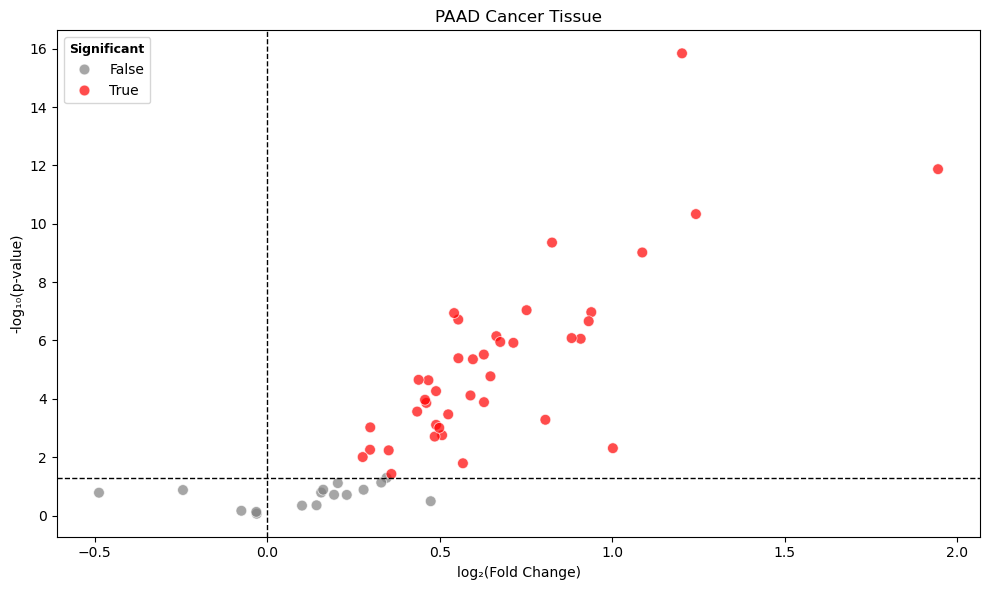

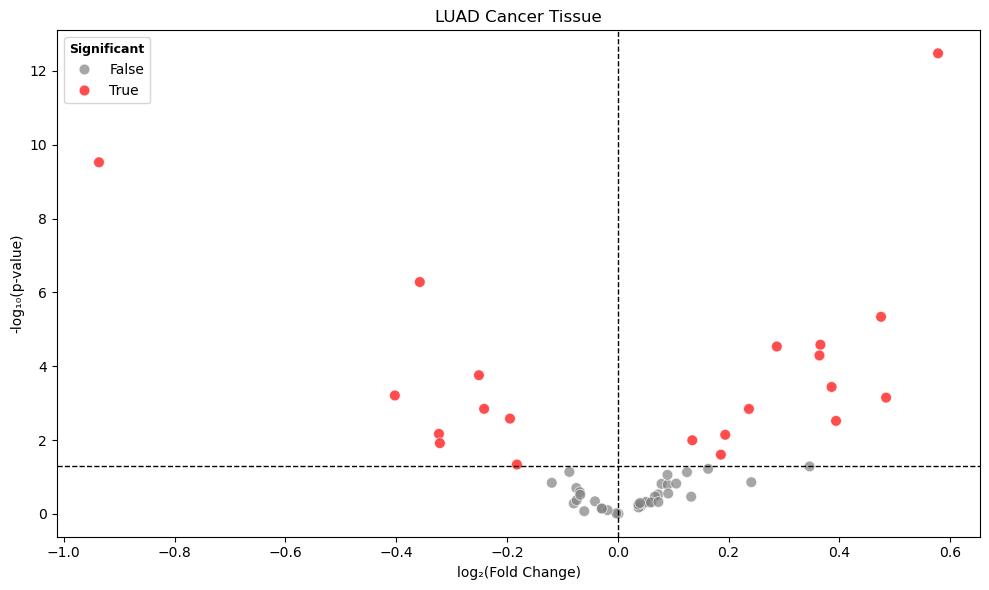

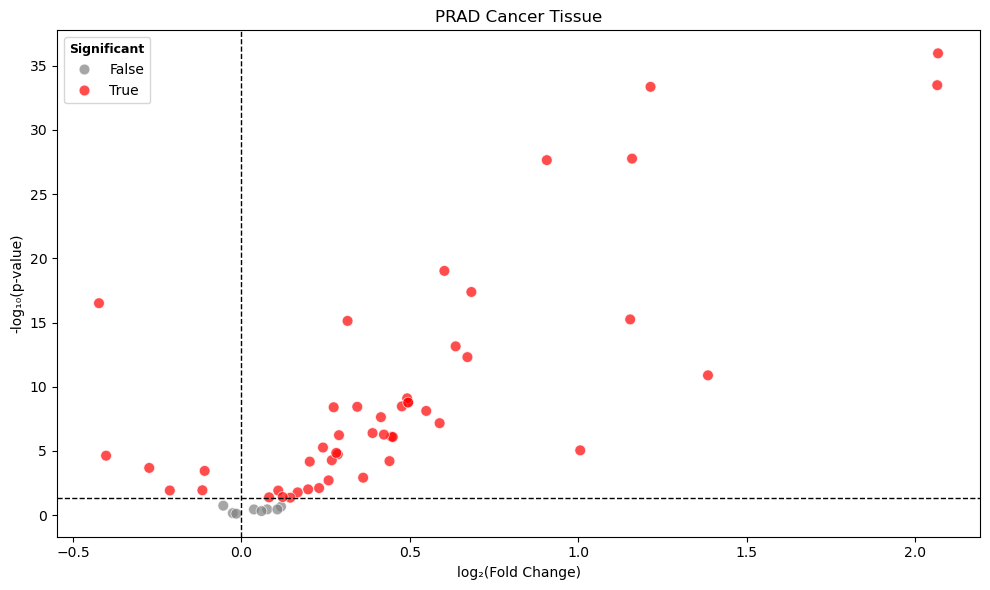

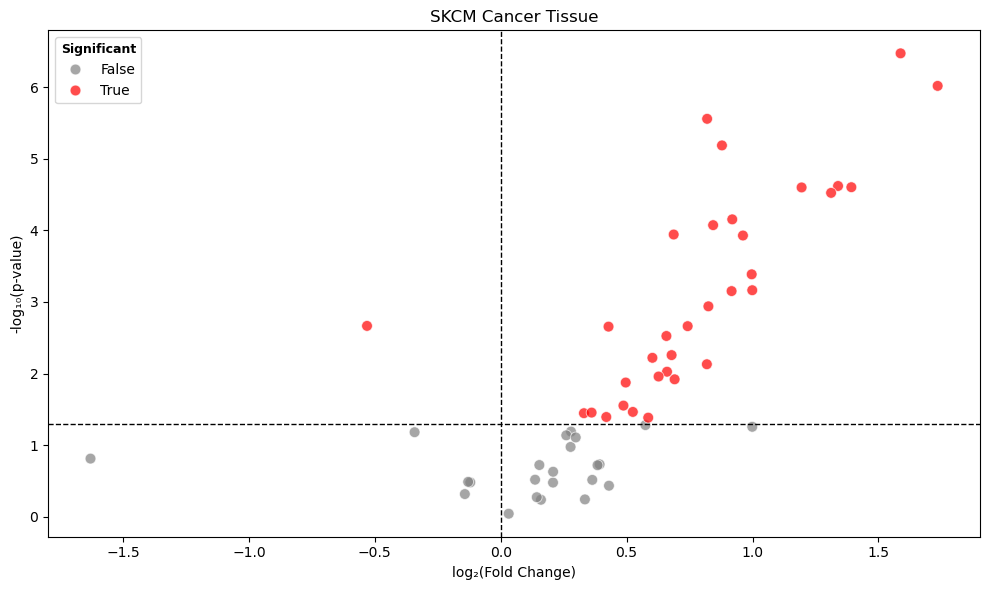

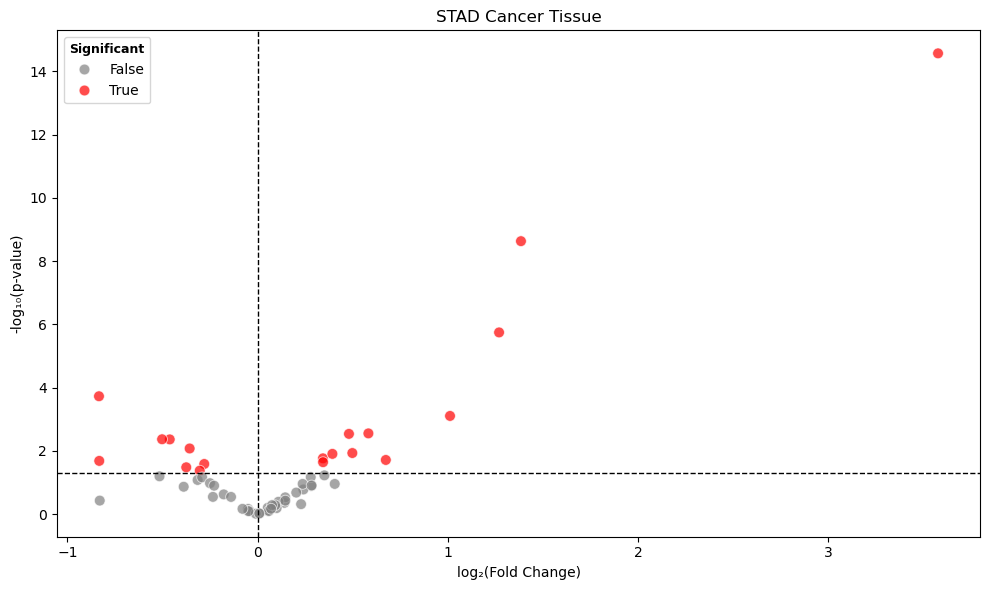

In [12]:
# Step 1: Define a function to analyze gene expression trends in a given cancer type
def analyze_gene_trends_cancer(file_path, gene_list, cancer='PAAD', title='Cancer Tissue'):
    
    # Load the integrated cancer dataset based on file extension
    df = pd.read_excel(file_path) if file_path.endswith('.xlsx') else pd.read_csv(file_path)
    
    # Extract the MIR100HG expression group (High vs Low)
    group = df[f'MIR100HG_Expression_Level_{cancer}']
    
    # Map target genes to their corresponding column names in the dataset
    full_gene_cols = {gene: f"tf_{gene}_expr_{cancer}" for gene in gene_list}
    
    # Identify genes that are available in the dataset
    available_genes = [gene for gene, col in full_gene_cols.items() if col in df.columns]
    if not available_genes:
        raise ValueError("None of the specified genes are present in the dataset.")
    
    # Select expression columns for the available genes
    gene_columns = [full_gene_cols[gene] for gene in available_genes]
    X = df[gene_columns].copy()
    X.columns = available_genes
    
    # Separate the data into MIR100HG-high and MIR100HG-low groups
    high = X[group == 'High']
    low = X[group == 'Low']
    
    # Step 2: Compute differential expression and statistical significance
    volcano_data = []
    for gene in available_genes:
        mean_high = high[gene].mean()
        mean_low = low[gene].mean()
        log2_fc = mean_high - mean_low
        pval = ttest_ind(high[gene], low[gene], equal_var=False).pvalue
        volcano_data.append((gene, log2_fc, pval))

    # Step 3: Build a volcano plot data frame
    volcano_df = pd.DataFrame(volcano_data, columns=['Gene', 'log2FC', 'p_value'])
    volcano_df['-log10(p_value)'] = -np.log10(volcano_df['p_value'])
    volcano_df['Significant'] = volcano_df['p_value'] < 0.05
    
    # Save the volcano table for the cancer type
    volcano_df.to_csv(f"{cancer}_volcano.csv", index=False)

    # Step 4: Create the volcano plot
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=volcano_df,
        x='log2FC',
        y='-log10(p_value)',
        hue='Significant',
        palette={True: 'red', False: 'grey'},
        s=60,
        alpha=0.7
    )

    # Add threshold lines for p-value and fold change
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.title(cancer + ' ' + title)
    plt.xlabel('log₂(Fold Change)')
    plt.ylabel('-log₁₀(p-value)')
    
    # Customize the plot legend
    legend = scatter.legend_
    if legend:
        legend.set_title('Significant', prop={'size': 9, 'weight': 'bold'})
        legend.set_bbox_to_anchor(None)
        legend.set_loc('upper left')
    
    plt.tight_layout()
    plt.show()

    return volcano_df

# Apply the function across multiple cancer types
cancer_names = ['PAAD', 'LUAD', 'PRAD', 'SKCM', 'STAD']

for cancer in cancer_names:
    cancer_tissue_file = f'Task1_Final_Integration_without_Methylation/Final_Integration_{cancer}_without_Methylation.xlsx'
    volcano_df = analyze_gene_trends_cancer(cancer_tissue_file, mir100hg_tfs, cancer, title='Cancer Tissue')

#### Subsection 3.2: Differential Expression Analysis in Normal Tissues

In this subsection, we define a parallel function to perform differential expression analysis across five normal tissues (Pancreas, Lung, Prostate, Skin, Stomach).

We load each integrated normal tissue dataset, separate samples into MIR100HG-high and MIR100HG-low groups, compute log2 fold changes and p-values for the available transcription factors, save the results to CSV files, and generate volcano plots for visualization. Each tissue is analyzed separately following the same standardized pipeline.

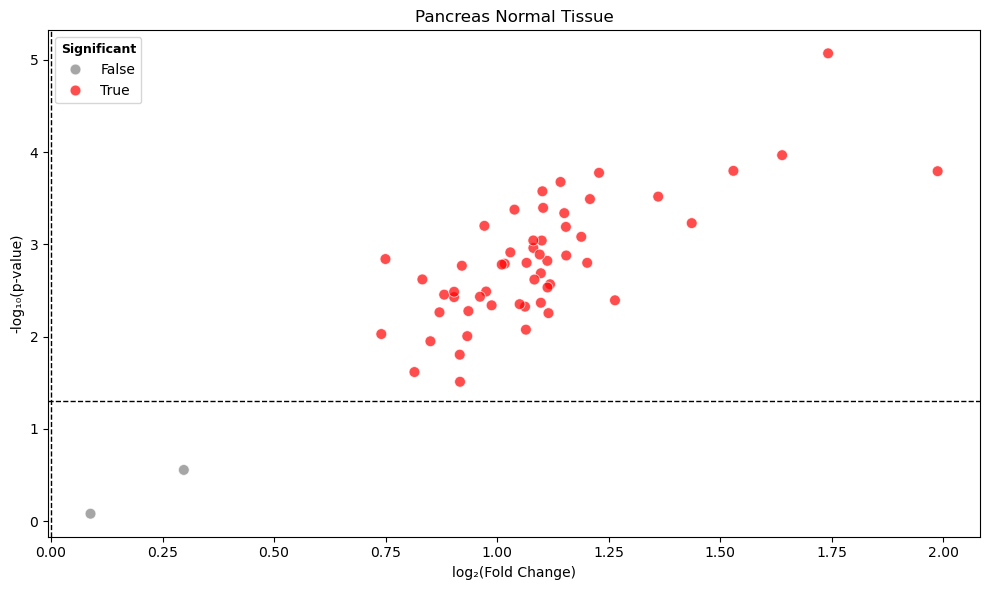

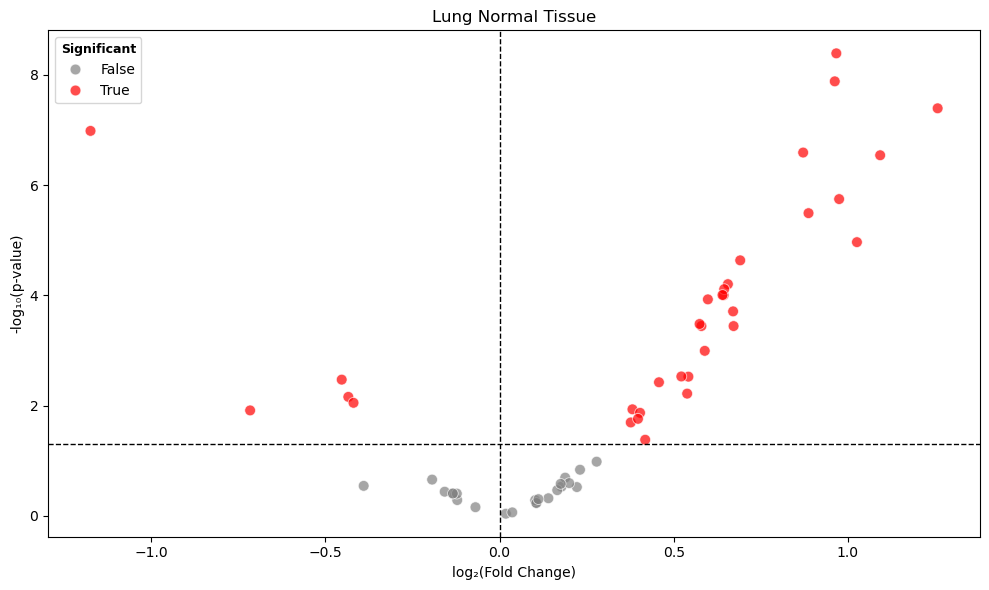

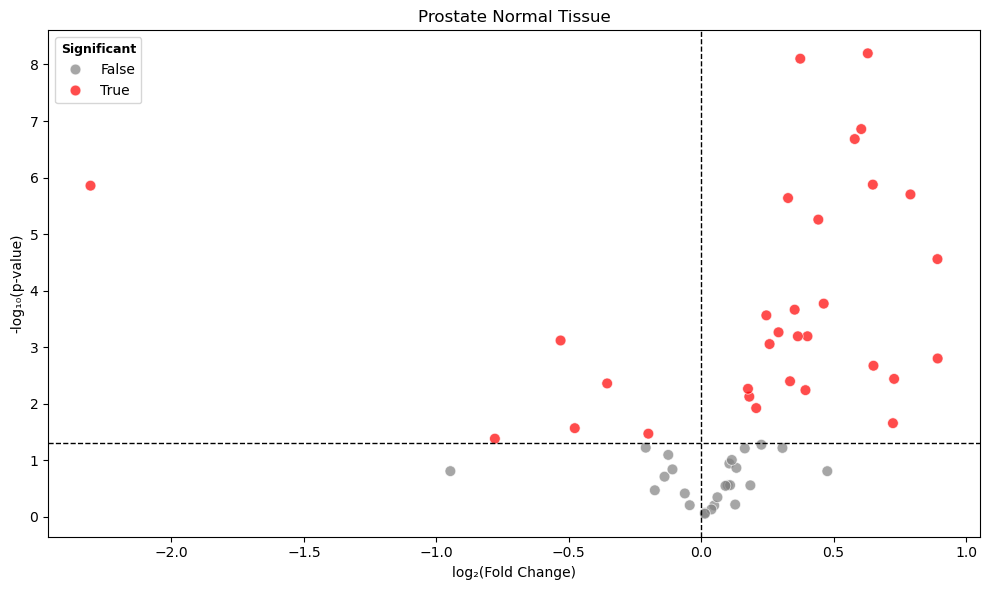

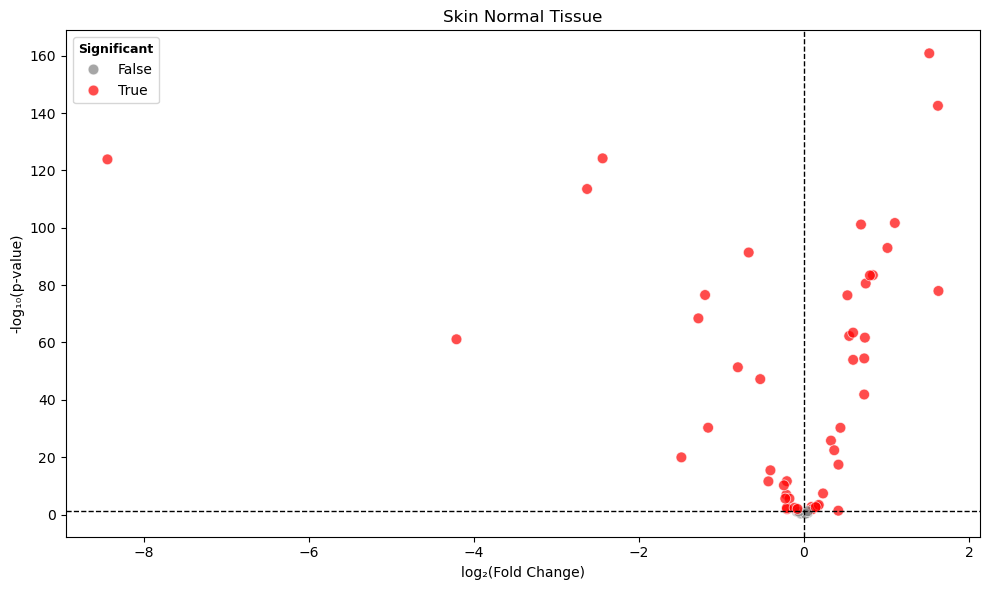

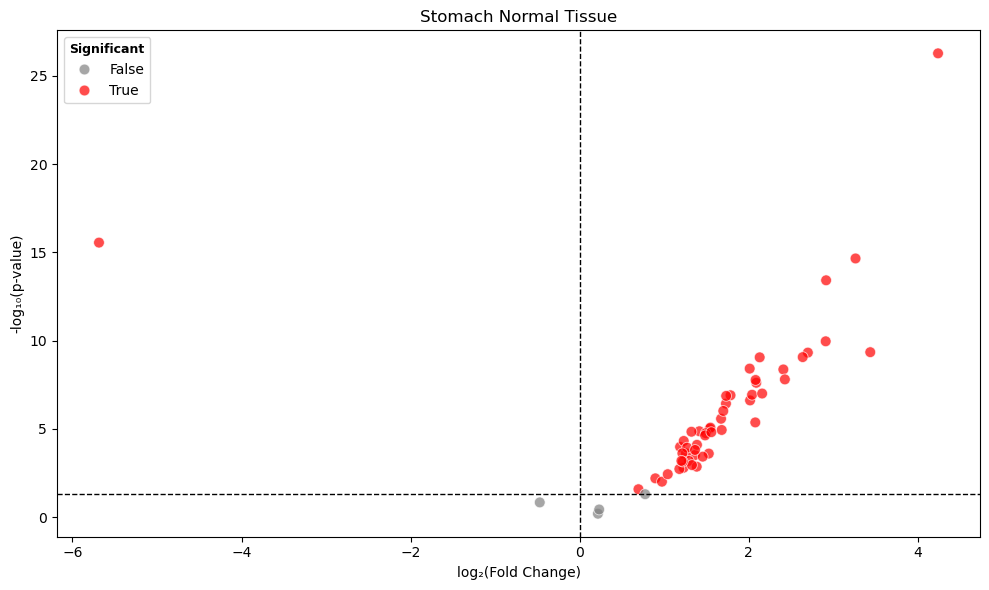

In [15]:
# Step 1: Define a function to analyze gene expression trends in normal tissue
def analyze_gene_trends(file_path, genes, site='Pancreas', title='Normal Tissue'):
    
    # Load the integrated normal tissue dataset based on file extension
    df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
    
    # Extract the MIR100HG expression group (High vs Low) for the specified tissue site
    group = df[f'MIR100HG_Expression_Level_{site.capitalize()}']
    
    # Filter the input gene list to retain only genes available in the dataset
    genes = [g for g in genes if g in df.columns]
    
    # Separate the expression data into MIR100HG-high and MIR100HG-low groups
    high = df[group == 'High'][genes]
    low = df[group == 'Low'][genes]
    
    # Step 2: Compute fold changes and p-values for differential expression
    volcano_data = []
    for gene in genes:
        mean_high = high[gene].mean()
        mean_low = low[gene].mean()
        log2_fc = mean_high - mean_low
        pval = ttest_ind(high[gene], low[gene], equal_var=False).pvalue
        volcano_data.append((gene, log2_fc, pval))

    # Build a DataFrame to store results for volcano plotting
    volcano_df = pd.DataFrame(volcano_data, columns=['Gene', 'log2FC', 'p_value'])
    volcano_df['-log10(p_value)'] = -np.log10(volcano_df['p_value'])
    volcano_df['Significant'] = volcano_df['p_value'] < 0.05
    
    # Save the volcano plot data to a CSV file
    volcano_df.to_csv(f"{site}_volcano.csv", index=False)

    # Step 3: Create a volcano plot for visualization
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        data=volcano_df,
        x='log2FC',
        y='-log10(p_value)',
        hue='Significant',
        palette={True: 'red', False: 'grey'},
        s=60,
        alpha=0.7
    )

    # Add threshold lines for p-value and fold change significance
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.title(site + ' ' + title)
    plt.xlabel('log₂(Fold Change)')
    plt.ylabel('-log₁₀(p-value)')
    
    # Customize the legend format
    legend = scatter.legend_
    if legend:
        legend.set_title('Significant', prop={'size': 9, 'weight': 'bold'})
        legend.set_bbox_to_anchor(None)
        legend.set_loc('upper left')
    
    plt.tight_layout()
    plt.show()

    return volcano_df

# Step 4: Apply the analysis function across multiple normal tissue types
site_names = ['Pancreas', 'Lung', 'Prostate', 'Skin', 'Stomach']

for site in site_names:
    
    # Specify the file path for each normal tissue dataset
    normal_file = f'Task2_Final_Integration/Final_Integration_{site}.xlsx'
    
    # Perform volcano analysis for each tissue
    volcano_df = analyze_gene_trends(normal_file, mir100hg_tfs, site, title='Normal Tissue')

### Section 4: Visualization of Gene-Level Differential Expression Across Tissues

In this section, we integrate differential expression (log2FC) results across multiple tissues for both cancer and normal datasets. Specifically, we construct annotated heatmaps to visualize log2 fold changes between MIR100HG-high and MIR100HG-low groups, marking statistically significant genes with stars. Separate heatmaps are created for cancer tissues and normal tissues by combining precomputed volcano plot data.

#### Subsection 4.1: Heatmap of Differential Expression Across Cancer Tissues

In this subsection, we load the volcano plot results for five cancer types (PAAD, LUAD, PRAD, SKCM, STAD) and aggregate them into a combined DataFrame.

Subsequently, we pivot the log2FC values to create a matrix with tissues as rows and genes as columns, generate a corresponding significance annotation matrix, and plot a diverging color heatmap centered at zero. Genes with p-values below 0.05 are annotated with stars to highlight significant expression differences between MIR100HG-high and MIR100HG-low groups.

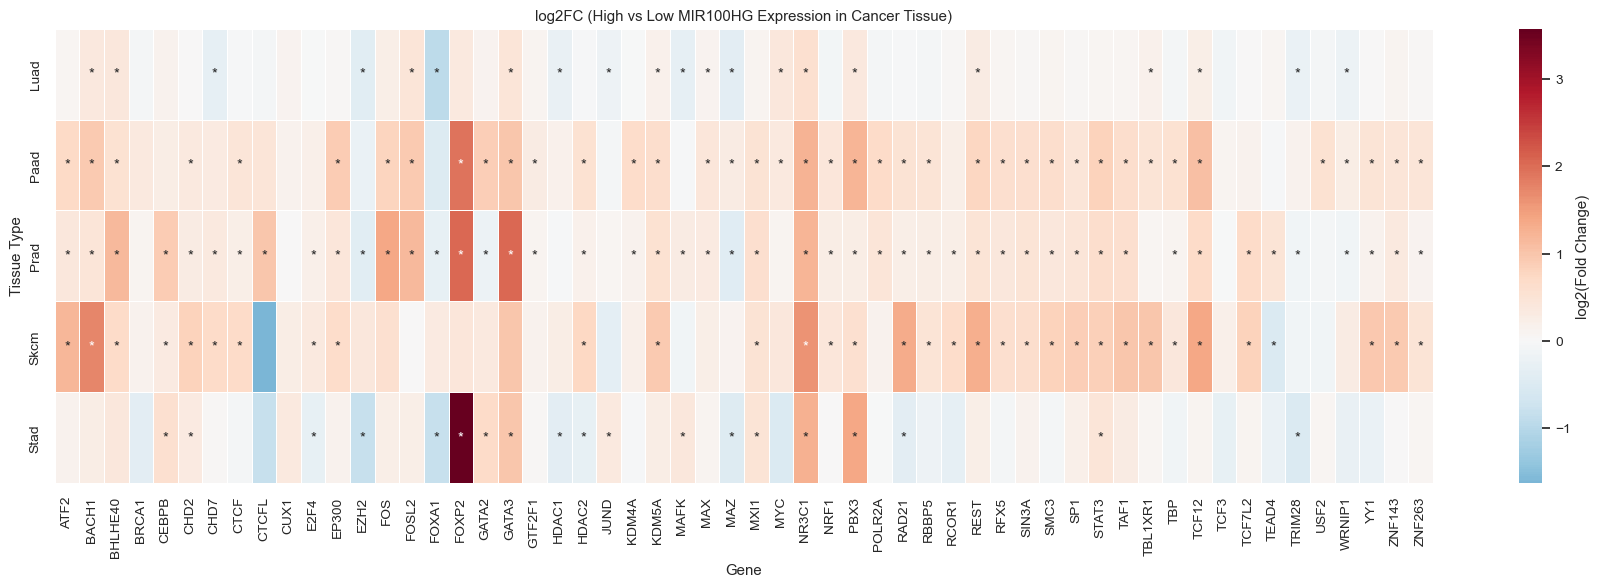

In [20]:
# Step 1: Load volcano analysis results for each cancer type

# Define the list of cancer tissue site names
site_names = ['PAAD', 'LUAD', 'PRAD', 'SKCM', 'STAD']

# Initialize a dictionary to store volcano results by tissue
volcano_dict = {}

# Read and annotate each volcano result
for site in site_names:
    df = pd.read_csv(f"{site}_volcano.csv")
    df['Site'] = site.capitalize()
    volcano_dict[site] = df

# Step 2: Combine volcano data across all cancer tissues

# Concatenate all cancer-specific volcano DataFrames into a single DataFrame
combined_df = pd.concat(volcano_dict.values())

# Pivot the combined DataFrame to create a matrix: rows = tissues, columns = genes, values = log2FC
heatmap_data = combined_df.pivot(index='Site', columns='Gene', values='log2FC')

# Step 3: Create a significance annotation matrix

# Define a helper function to mark genes with statistical significance
def significance_marker(pval):
    return '*' if pval < 0.05 else ''

# Apply the significance marker function to the volcano data
sig_data = combined_df.copy()
sig_data['significant'] = sig_data['p_value'].apply(significance_marker)

# Pivot the significance markers into a matrix aligned with the heatmap
annot_data = sig_data.pivot(index='Site', columns='Gene', values='significant')

# Step 4: Plot the heatmap of log2FC values annotated by significance

# Set figure size and font scaling for the heatmap
plt.figure(figsize=(18, 6))
sns.set(font_scale=0.9)

# Create a diverging color heatmap centered at zero (no fold change)
ax = sns.heatmap(
    heatmap_data,
    annot=annot_data,        # Annotate with significance stars
    fmt='s',                 # Format as string annotations
    cmap='RdBu_r',            # Red-to-blue diverging color map
    center=0,                 # Center color at log2FC = 0
    linewidths=0.5,           # Thin gridlines between cells
    cbar_kws={'label': 'log2(Fold Change)'}
)

# Add plot title and axis labels
plt.title("log2FC (High vs Low MIR100HG Expression in Cancer Tissue)")
plt.ylabel("Tissue Type")
plt.xlabel("Gene")

# Apply tight layout to prevent label overlapping
plt.tight_layout()

# Display the heatmap
plt.show()

#### Subsection 4.2: Heatmap of Differential Expression Across Normal Tissues

In this subsection, we load the volcano plot results for five normal tissues (Pancreas, Lung, Prostate, Skin, Stomach) and concatenate them into a unified DataFrame.

Subsequently, we pivot the log2FC values into a tissue-by-gene matrix, create a significance annotation matrix based on p-value thresholds, and plot a diverging color heatmap to visualize differential expression patterns. Significant genes are annotated with stars to facilitate quick interpretation.

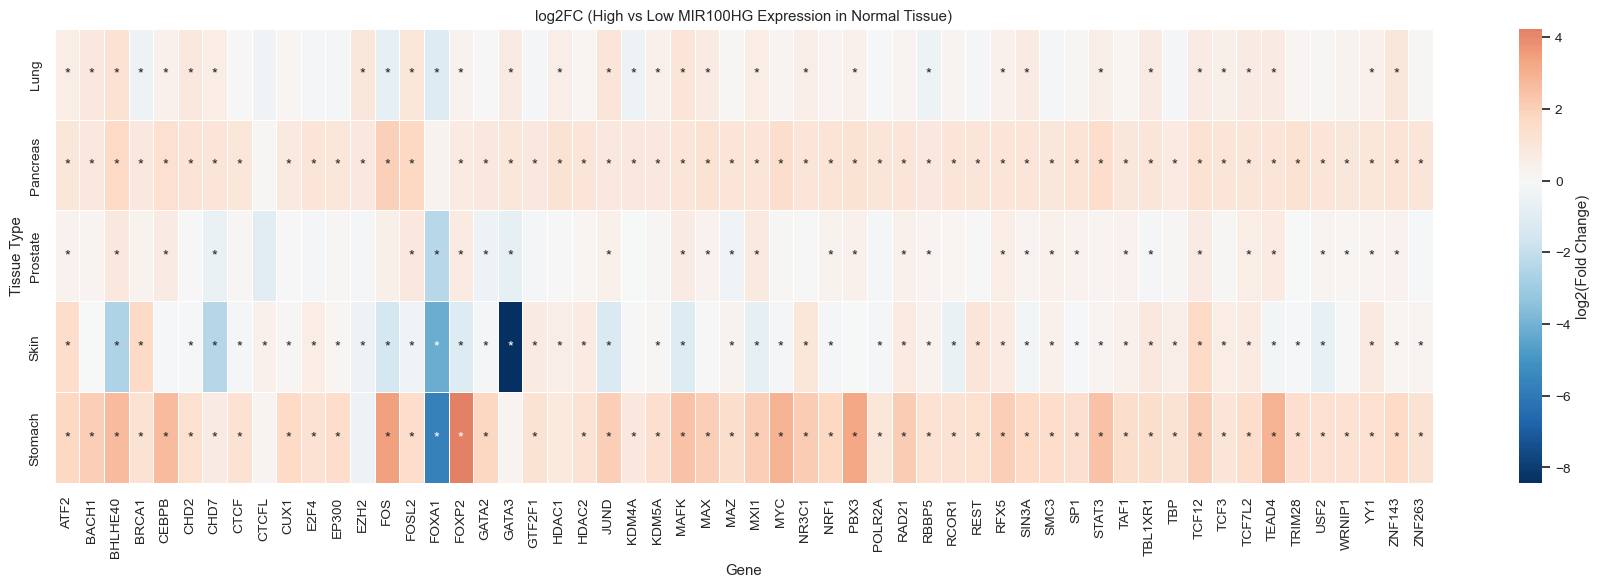

In [24]:
# Step 1: Load volcano analysis results for each tissue type

# Define the list of normal tissue site names
site_names = ['pancreas', 'lung', 'prostate', 'skin', 'stomach']

# Initialize a dictionary to store volcano results by tissue
volcano_dict = {}

# Read and annotate each volcano result
for site in site_names:
    df = pd.read_csv(f"{site}_volcano.csv")
    df['Site'] = site.capitalize()
    volcano_dict[site] = df

# Step 2: Combine volcano data across tissues

# Concatenate all tissue-specific volcano DataFrames into a single DataFrame
combined_df = pd.concat(volcano_dict.values())

# Pivot the combined DataFrame to create a matrix: rows = tissues, columns = genes, values = log2FC
heatmap_data = combined_df.pivot(index='Site', columns='Gene', values='log2FC')

# Step 3: Generate significance annotation matrix for the heatmap

# Define a helper function to mark genes with significant expression changes
def significance_marker(pval):
    return '*' if pval < 0.05 else ''

# Apply significance marking to the volcano data
sig_data = combined_df.copy()
sig_data['significant'] = sig_data['p_value'].apply(significance_marker)

# Pivot the significance markers into a matrix aligned with the heatmap
annot_data = sig_data.pivot(index='Site', columns='Gene', values='significant')

# Step 4: Plot the heatmap of log2FC values annotated by significance

# Set figure size and font scaling for the heatmap
plt.figure(figsize=(18, 6))
sns.set(font_scale=0.9)

# Create a diverging color heatmap centered at zero (no expression change)
ax = sns.heatmap(
    heatmap_data,
    annot=annot_data,        # Annotate with significance stars
    fmt='s',                 # Format as string annotations
    cmap='RdBu_r',            # Red-to-blue diverging color map
    center=0,                 # Center color at log2FC = 0
    linewidths=0.5,           # Thin gridlines between cells
    cbar_kws={'label': 'log2(Fold Change)'}
)

# Add plot title and axis labels
plt.title("log2FC (High vs Low MIR100HG Expression in Normal Tissue)")
plt.ylabel("Tissue Type")
plt.xlabel("Gene")

# Apply tight layout to prevent overlap
plt.tight_layout()

# Display the heatmap
plt.show()

### Section 5: Random Forest Modeling of MIR100HG-Associated Transcription Factors

In this section, we train Random Forest classifiers to identify important transcription factors (TFs) associated with MIR100HG expression groups (High vs Low) in both cancer and normal tissues.

We conduct separate modeling for PAAD cancer tissue and Pancreas normal tissue, extract feature importance scores, and compare the top-ranked TFs between the two contexts using side-by-side tabular comparison.

#### Subsection 5.1: Random Forest Modeling and Feature Importance Analysis in PAAD Cancer Tissue

In this subsection, we preprocess the PAAD cancer tissue dataset, encoding gender and MIR100HG expression groups numerically.

We define the feature matrix and labels, perform a train-test split, and train a Random Forest classifier. We evaluate the model using a confusion matrix and classification report, and extract the top 10 most important transcription factors based on feature importance scores, which are formatted into a clean summary table.

In [30]:
# Step 1: Prepare the dataset for Random Forest modeling
df_rf = df_pa.copy()

# Set patient ID column as the DataFrame index
df_rf.set_index(df_rf.columns[0], inplace=True)

# Encode gender as numeric: MALE as 1, FEMALE as 0
df_rf[df_rf.columns[0]] = df_rf[df_rf.columns[0]].map({'MALE': 1, 'FEMALE': 0})

# Encode MIR100HG expression group: High as 1, Low as 0
df_rf[df_rf.columns[2]] = df_rf[df_rf.columns[2]].map({'High': 1, 'Low': 0})

# Define features (X) and labels (y) for classification
X = pd.concat([df_rf.iloc[:, [0]], df_rf.iloc[:, 4:]], axis=1)
y = df_rf.iloc[:, 2]

# Step 2: Check for missing labels in the dataset
num_nan = y.isna().sum()
total = len(y)
nan_ratio = num_nan / total

print("\nCheck label column completeness for Cancer data:")
print(f"Number of NaN values in the label column: {num_nan}")
print(f"Total number of samples: {total}")
print(f"Proportion of NaN values: {nan_ratio:.2%}\n")

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate model performance
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(pd.DataFrame(
    cm,
    index=["Actual Low", "Actual High"],
    columns=["Predicted Low", "Predicted High"]
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 7: Analyze feature importances
feature_names = X.columns
importances = model.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Step 8: Format and display the top 10 most important features
top10_cancer = feat_imp_df.head(10).reset_index(drop=True)

top10_cancer['Feature'] = top10_cancer['feature'].str.replace('tf_', '', regex=False).str.replace('_expr_PAAD', '', regex=False)

top10_cancer_display = pd.DataFrame({
    '': range(1, 11),
    'Transcription Factor': top10_cancer['Feature'],
    'Importance': top10_cancer['importance'].round(6)
})

print("\nTop 10 Important Features for Cancer Tissue (PAAD):")
display(top10_cancer_display.style.hide(axis="index"))


Check label column completeness for Cancer data:
Number of NaN values in the label column: 0
Total number of samples: 95
Proportion of NaN values: 0.00%

Confusion Matrix:
             Predicted Low  Predicted High
Actual Low               7               0
Actual High              3               9

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.75      0.86        12

    accuracy                           0.84        19
   macro avg       0.85      0.88      0.84        19
weighted avg       0.89      0.84      0.84        19


Top 10 Important Features for Cancer Tissue (PAAD):


,Transcription Factor,Importance
1,PBX3,0.100703
2,NR3C1,0.093506
3,POLR2A,0.069400
4,STAT3,0.068776
5,TBP,0.057244
6,BACH1,0.049348
7,EZH2,0.049165
8,FOXP2,0.043627
9,TCF12,0.041589
10,HDAC2,0.033037


#### Subsection 5.2: Random Forest Modeling and Feature Importance Analysis in Pancreas Normal Tissue

In this subsection, we repeat the Random Forest modeling process using the Pancreas normal tissue dataset.

We encode categorical variables, perform train-test splitting, fit the model, evaluate predictions, and extract the top 10 most important transcription factors contributing to MIR100HG expression group classification. The feature names are cleaned, and the results are organized into a summary table for display.

In [33]:
# Step 1: Prepare the dataset for Random Forest modeling
df_rf_normal = df_pan.copy()

# Set patient ID column as the DataFrame index
df_rf_normal.set_index(df_rf_normal.columns[0], inplace=True)

# Encode gender as numeric: MALE as 1, FEMALE as 0
df_rf_normal[df_rf_normal.columns[0]] = df_rf_normal[df_rf_normal.columns[0]].map({'MALE': 1, 'FEMALE': 0})

# Encode MIR100HG expression group: High as 1, Low as 0
df_rf_normal[df_rf_normal.columns[2]] = df_rf_normal[df_rf_normal.columns[2]].map({'High': 1, 'Low': 0})

# Define features and labels for classification
X_normal = pd.concat([df_rf_normal.iloc[:, [0]], df_rf_normal.iloc[:, 4:]], axis=1)
y_normal = df_rf_normal.iloc[:, 2]

# Step 2: Check for missing labels
num_nan_normal = y_normal.isna().sum()
total_normal = len(y_normal)
nan_ratio_normal = num_nan_normal / total_normal

print("\nCheck label column completeness for Normal Tissue data:")
print(f"Number of NaN values in the label column (Normal Tissue): {num_nan_normal}")
print(f"Total number of samples (Normal Tissue): {total_normal}")
print(f"Proportion of NaN values: {nan_ratio_normal:.2%}")

# Step 3: If no missing labels, proceed to train-test split and modeling
if num_nan_normal == 0:
    X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
        X_normal, y_normal, test_size=0.2, random_state=42
    )

    model_normal = RandomForestClassifier(random_state=42)
    model_normal.fit(X_train_normal, y_train_normal)

    y_pred_normal = model_normal.predict(X_test_normal)

    cm_normal = confusion_matrix(y_test_normal, y_pred_normal)
    print("\nConfusion Matrix for Normal Tissue (clear version):")
    print(pd.DataFrame(
        cm_normal,
        index=["Actual Low", "Actual High"],
        columns=["Predicted Low", "Predicted High"]
    ))

    print("\nClassification Report for Normal Tissue:")
    print(classification_report(y_test_normal, y_pred_normal))

    feature_names_normal = X_normal.columns
    importances_normal = model_normal.feature_importances_

    feat_imp_df_normal = pd.DataFrame({
        'feature': feature_names_normal,
        'importance': importances_normal
    }).sort_values(by='importance', ascending=False)

    # Step 4: Format and display the top 10 most important features
    top10_normal = feat_imp_df_normal.head(10).reset_index(drop=True)

    top10_normal['Feature'] = top10_normal['feature'].str.replace('tf_', '', regex=False)
    top10_normal['Feature'] = top10_normal['Feature'].str.replace('_expr_Pancreas', '', regex=False)
    top10_normal['Feature'] = top10_normal['Feature'].str.replace('_expr_PAAD', '', regex=False)

    top10_normal_display = pd.DataFrame({
        '': range(1, 11),
        'Transcription Factor': top10_normal['Feature'],
        'Importance': top10_normal['importance'].round(6)
    })

# Step 5: Display the clean DataFrame
print("\nTop 10 Important Features for Normal Tissue (Pancreas):")
display(top10_normal_display.style.hide(axis="index"))


Check label column completeness for Normal Tissue data:
Number of NaN values in the label column (Normal Tissue): 0
Total number of samples (Normal Tissue): 112
Proportion of NaN values: 0.00%

Confusion Matrix for Normal Tissue (clear version):
             Predicted Low  Predicted High
Actual Low              11               1
Actual High              1              10

Classification Report for Normal Tissue:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.91      0.91      0.91        11

    accuracy                           0.91        23
   macro avg       0.91      0.91      0.91        23
weighted avg       0.91      0.91      0.91        23


Top 10 Important Features for Normal Tissue (Pancreas):


,Transcription Factor,Importance
1,RCOR1,0.098176
2,NRF1,0.072036
3,MAX,0.068415
4,TCF12,0.066259
5,ATF2,0.049656
6,CHD2,0.047056
7,REST,0.045409
8,EP300,0.044156
9,TAF1,0.044062
10,NR3C1,0.038185


#### Subsection 5.3: Comparative Analysis of Top Transcription Factors Between Normal and Cancer Tissues

In this subsection, we align and compare the top 10 transcription factors ranked by importance from the cancer and normal tissue Random Forest models.

In [37]:
# Step 1: Extract top 10 features from Cancer Tissue model
top10_cancer = feat_imp_df.head(10).reset_index(drop=True)

# Step 2: Extract top 10 features from Normal Tissue model
top10_normal = feat_imp_df_normal.head(10).reset_index(drop=True)

# Step 3: Clean feature names in the Cancer Tissue list
top10_cancer['Feature'] = top10_cancer['feature'].str.replace('tf_', '', regex=False).str.replace('_expr_PAAD', '', regex=False)

# Step 4: Clean feature names in the Normal Tissue list
top10_normal['Feature'] = top10_normal['feature'].str.replace('tf_', '', regex=False)
top10_normal['Feature'] = top10_normal['Feature'].str.replace('_expr_Pancreas', '', regex=False)
top10_normal['Feature'] = top10_normal['Feature'].str.replace('_expr_PAAD', '', regex=False)

# Step 5: Build a comparison DataFrame aligning Normal and Cancer top features
comparison_df = pd.DataFrame({
    'Top 10 TFs': range(1, 11),
    'Normal Tissues': top10_normal['Feature'],
    'Cancer Tissues': top10_cancer['Feature']
})

# Step 6: Display the side-by-side comparison table
print("\nComparison of Top 10 Transcription Factors:")
display(
    comparison_df.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'left'})
)


Comparison of Top 10 Transcription Factors:


Top 10 TFs,Normal Tissues,Cancer Tissues
1,RCOR1,PBX3
2,NRF1,NR3C1
3,MAX,POLR2A
4,TCF12,STAT3
5,ATF2,TBP
6,CHD2,BACH1
7,REST,EZH2
8,EP300,FOXP2
9,TAF1,TCF12
10,NR3C1,HDAC2
